## A TRANSFORMER MODEL APPROACH TO CATARACT IMAGE CLASSIFICATION (DTSA 5511 FINAL PROJECT)

## PROBLEM DESCRIPTION
This final project is a continuation of previous research that I worked on, which focuses on using machine learning to perform cataract detection and cataract image classification. Results from this research can benefit people (doctors, nurses, healthcare professionals, etc.) in being able to identify early stages of cataract development and provide medical treatment in those early stages. The main goal in my previous effort for this research was to apply transfer learning and achieve high model accuracy with a given base model. Other developers used VGG19-basd models and ResNet50-based models to achieve success for this use case. I achieved similar success with a modified ResNet50-based model (with 97% model accuracy), which did well when compared to other models that I worked with (a DenseNet-based model and a custom CNN model). 

The main objective of this project is to explore a transformer model approach to this use case and determine whether or not the model can achieve success in learning from the data. If the transformer is able to achieve success, the second part of the objective is to identify hyperparameters to modify in order to optimize the transformer even further. The data source for this project is from the following Kaggle source and all project content can be found in the following Github repository link.

Kaggle Data Source: https://www.kaggle.com/code/taha07/cataract-prediction-using-vgg19/input

Github Repository: https://github.com/IsraelsLibrary/DTSA_5511_Final_Project 

In [412]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [413]:
# Importing required libraries for exploratory data analysis (EDA) and data processing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imageio.v2 as imageio
import cv2
import random

In [414]:
# Setting up variables to store the data after reading in the image files and labels.
preprocessed_images_path = "data/preprocessed_images/"
full_df = "data/full_df.csv"


# Check if the training labels exist before attempting to read the file
if os.path.exists(full_df):
    # Open and read the file
    with open(full_df, 'r') as file:
        eyes_df = pd.read_csv(file)
        df = eyes_df
        file.close()
else:
    print(f"The file {full_df} does not exist in the specified folder.")

## EXPLORATORY DATA ANALYSIS
The data includes a collection of preprocessed images, as well as a set of training images and test images. For the scope of this project, I only focus on the preprocessed images, and splitting the collection into training and test sets. I create and utilize two helper methods that aid in cleaning the image data and labels (in order to make sure there are no NULL values nor missing entries). From the data file, I found that there are 6,392 entries (each corresponding to a given patient), and I generated a correlation matrix heatmap as well as a series of pair plots to track correlations between different features. 

Additional data visualizations below indicate the proportion of images that I am working with (where 6% of the total number of images are images that show the presence of cataracts). The included histogram reveals a frequency distribution of image pixel values for all images in the dataset. I also display a sample image below to show what kind of images will be involved in the process.

In preparation of the machine learning process, I discovered a key feature that would help in defining the labels needed for training the potential machine learning model. The data file contains features related to the medical information for each patient. One feature (titled 'C') indicates whether or not if a given patient has cataracts in either eye. This information, along with other features, help in processing the data and setting up for a test for binary classification of images (images of normal eyes and images of eyes with cataracts). 

Like other developers who utilized this dataset, I followed a similar format in preprocessing the dataset. I divided the dataset into two smaller datasets (one dataset for normal eye images and the other dataset for eye images with cataracts). I form a new dataset where I assign each image with either a '0' or '1' ('0' for normal eye images, and '1' for cataract eye images). From this new dataset, I assign the images to one variable, which will form a list of multidimensional arrays. The assigned zeroes and ones will form a different array, which will serve as the labels for the machine learning model. From here, I perform a 70/30 split of each dataset, where 70% will serve as the training data and 30% will be used as test data for evaluation purposes.

In [433]:
print(f'Total number of entries from the data file: {len(eyes_df)}')

Total number of entries from the data file: 6392


In [422]:
# Helper functions for cleaning the data labels and image datasets
def clean_data(table):
    table = table.dropna().any()
    if table.isnull().sum() > 0:
        clean_data(table)
        
def clean_image_data(data):
    cleaned = [ele for ele in data if not np.isnan(ele).any()]
    return cleaned
            

In [22]:
# Reading in the image files
images_list = file_list = os.listdir(preprocessed_images_path)
preprocessed_images = [file for file in images_list if file.lower().endswith('.jpg')]

In [23]:
print(f'Number of total images: {len(preprocessed_images)}')
print(f'Number of available labels: {len(eyes_df)}')

Number of total images: 6392
Number of available labels: 6392


In [24]:
eyes_df_correlation = eyes_df.corr()

/var/folders/k1/f3l1yym17tl9cvqg5972snr00000gn/T/ipykernel_69064/133834528.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  eyes_df_correlation = eyes_df.corr()


<Axes: >

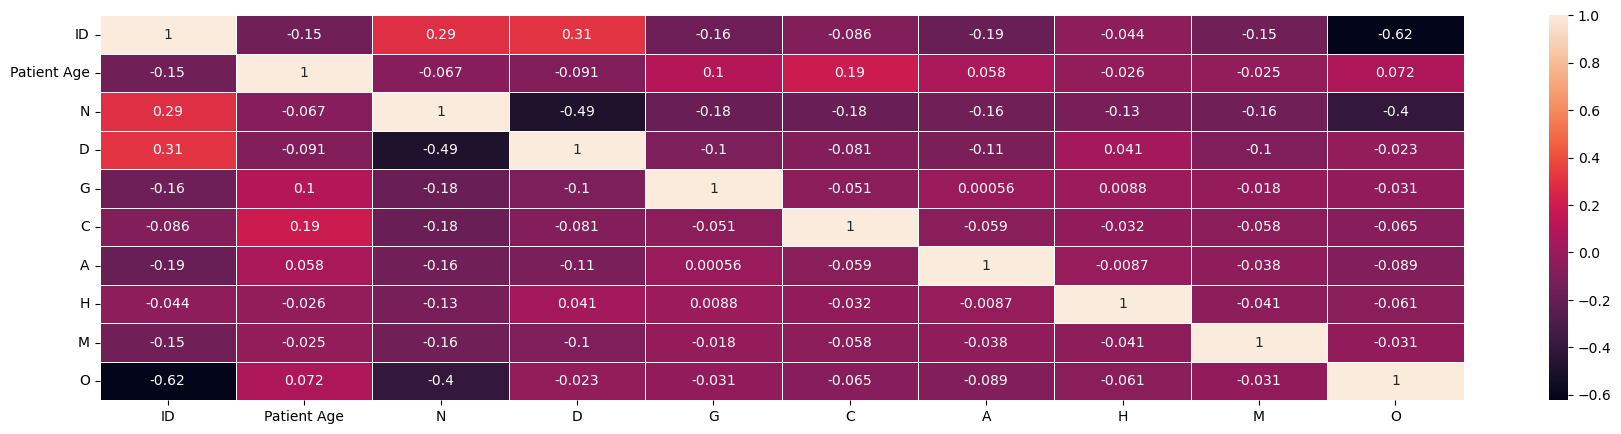

In [25]:
# Generating a correlation matrix heatmap for data features (more details about the features can be found
# in the data source.)
import seaborn as sns
fig, ax = plt.subplots(figsize=(22,5))
sns.heatmap(eyes_df_correlation, annot=True, linewidth=0.5)

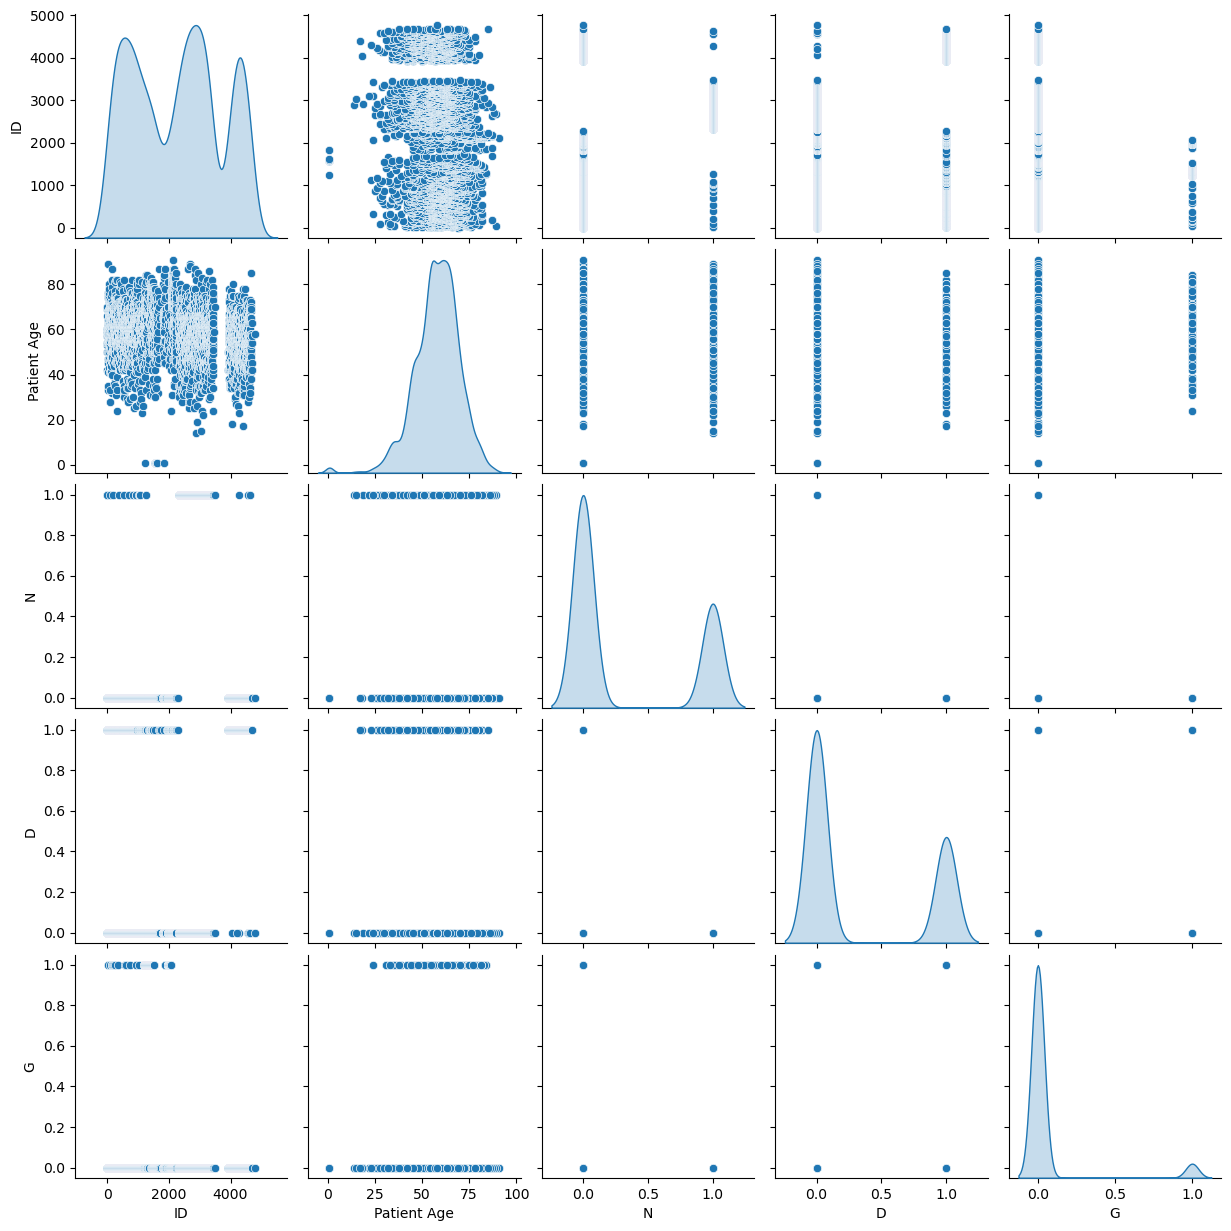

In [26]:
# Generating a series of pair plots for data features
sns.pairplot(eyes_df.iloc[:,:10], diag_kind='kde')

In [27]:
# Removing features not relevant for the project
eyes_df = eyes_df.drop(['ID','Patient Sex', 'N', 'D', 'G', 'A', 'H', 'M', 'O',
                        'filepath', 'labels', 'target'], axis='columns')


eyes_df = pd.DataFrame(eyes_df)

In [28]:
print(eyes_df)

      Patient Age    Left-Fundus    Right-Fundus  \
0              69     0_left.jpg     0_right.jpg   
1              57     1_left.jpg     1_right.jpg   
2              42     2_left.jpg     2_right.jpg   
3              53     4_left.jpg     4_right.jpg   
4              50     5_left.jpg     5_right.jpg   
...           ...            ...             ...   
6387           63  4686_left.jpg  4686_right.jpg   
6388           42  4688_left.jpg  4688_right.jpg   
6389           54  4689_left.jpg  4689_right.jpg   
6390           57  4690_left.jpg  4690_right.jpg   
6391           58  4784_left.jpg  4784_right.jpg   

                               Left-Diagnostic Keywords  \
0                                              cataract   
1                                         normal fundus   
2     laser spot，moderate non proliferative retinopathy   
3                           macular epiretinal membrane   
4                moderate non proliferative retinopathy   
...                  

In [29]:
# Matching the list of mentioned image files with the collected images in the local repository
files = list(eyes_df['filename'])
for image in preprocessed_images:
    if image not in files:
        preprocessed_images.remove(image)
        
print(len(preprocessed_images))
print(len(eyes_df['filename']))

6392
6392


(-0.5, 511.5, 511.5, -0.5)

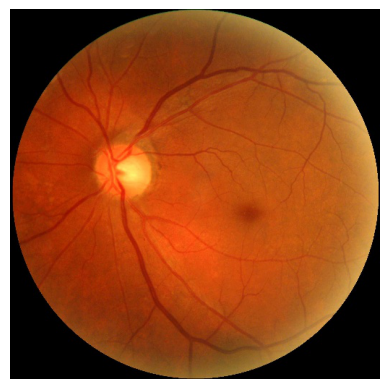

In [31]:
# Displaying a sample image from the dataset
sample_image = os.path.join(preprocessed_images_path, preprocessed_images[0])
image = Image.open(sample_image)
plt.imshow(image)
plt.axis('off')

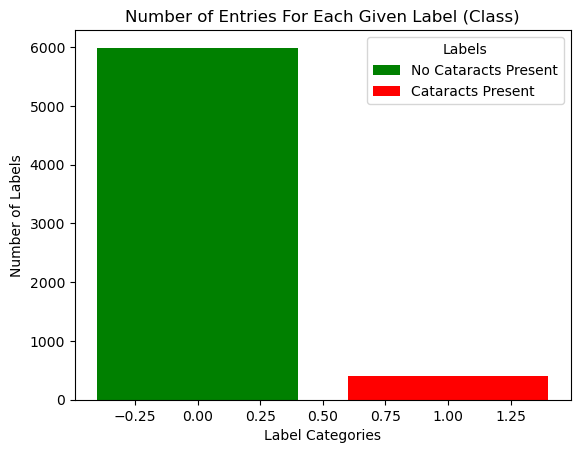

In [32]:
# Generating a bar plot, showing the proportion of images of cataract eyes and images of normal eyes.
eyes_df_plot = eyes_df.groupby('C')['C'].count()

fig, ax = plt.subplots()
bars = ax.bar(eyes_df_plot.index, eyes_df_plot, color=['green', 'red'])

plt.xlabel('Label Categories')
plt.ylabel('Number of Labels')
plt.title('Number of Entries For Each Given Label (Class)')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed

# Adding legend using bars and labels
ax.legend(bars, ['No Cataracts Present', 'Cataracts Present'], title='Labels')

plt.show()

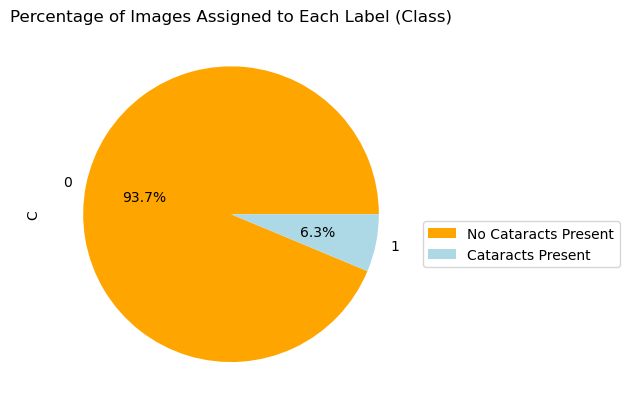

In [33]:
# Generating a pie chart, showing the proportion of images of cataract eyes and images of normal eyes.
label_distribution = eyes_df['C'].value_counts()
label_distribution.plot(kind='pie', autopct='%1.1f%%', colors=['orange', 'lightblue'])
plt.title('Percentage of Images Assigned to Each Label (Class)')

plt.legend(labels=['No Cataracts Present', 'Cataracts Present'], loc='upper left', bbox_to_anchor=(1, 0.5))
plt.show()


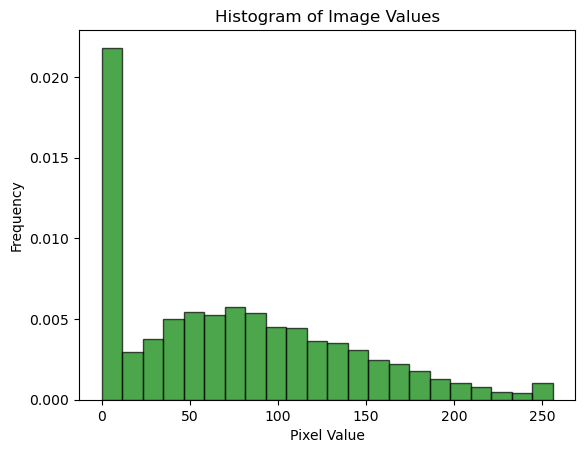

In [34]:
# Plotting a histogram to show the frequency distribution of image values for all collected images.
image_values = np.concatenate([array.flatten() for array in eye_image_arrays])

# Plot histogram
plt.hist(image_values, bins=22, range=(0, 256), density=True, alpha=0.7, color='green', edgecolor='black')
plt.title('Histogram of Image Values')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

In [51]:
# Preprocessing the input data by first splitting the data into two smaller datasets (one for cataract images 
# and the other for normal images)
lefteye_normal = df[df["Left-Diagnostic Keywords"].str.contains("normal fundus")]
lefteye_normal = lefteye_normal[lefteye_normal["C"]==0]["Left-Fundus"]

righteye_normal = df[df["Right-Diagnostic Keywords"].str.contains("normal fundus")]
righteye_normal = righteye_normal[righteye_normal["C"]==0]["Right-Fundus"]

normals_all = np.concatenate([lefteye_normal.values, righteye_normal.values])
normals = normals_all[:500]

lefteye_cataracts = df[df["Left-Diagnostic Keywords"].str.contains("cataract")]
lefteye_cataracts_allpatients = lefteye_cataracts[lefteye_cataracts["C"]==1]
lefteye_cataracts = lefteye_cataracts[lefteye_cataracts["C"]==1]["Left-Fundus"]

righteye_cataracts = df[df["Right-Diagnostic Keywords"].str.contains("cataract")]
righteye_cataracts_allpatients = righteye_cataracts[righteye_cataracts["C"]==1]
righteye_cataracts = righteye_cataracts[righteye_cataracts["C"]==1]["Right-Fundus"]

cataracts = np.concatenate([lefteye_cataracts.values, righteye_cataracts.values])
cataracts = cataracts[:588]


In [424]:
# Using the smaller datasets and images to construct a new dataset of images and assigned labels:
# '0' for normal images and '1' for cataract images.
row = 256
col = 256

dataset = []
for img_file in normals:
    try:
        img_data = cv2.imread(os.path.join(preprocessed_images_path, img_file))
        img = cv2.resize(img_data, (row,col))
        #img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    except:
        continue
    clean_image_data(np.array(img))
    dataset.append([np.array(img), np.array(0)])
random.shuffle(dataset)

for img_file in cataracts:
    try:
        img_data = cv2.imread(os.path.join(preprocessed_images_path, img_file))
        img = cv2.resize(img_data, (row,col))
        #img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    except:
        continue
    clean_image_data(np.array(img))
    dataset.append([np.array(img), np.array(1)])


random.shuffle(dataset)

[ WARN:0@42860.853] global loadsave.cpp:248 findDecoder imread_('data/preprocessed_images/222_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@42860.898] global loadsave.cpp:248 findDecoder imread_('data/preprocessed_images/393_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@42860.928] global loadsave.cpp:248 findDecoder imread_('data/preprocessed_images/528_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@42860.941] global loadsave.cpp:248 findDecoder imread_('data/preprocessed_images/593_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@42860.977] global loadsave.cpp:248 findDecoder imread_('data/preprocessed_images/844_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@42860.990] global loadsave.cpp:248 findDecoder imread_('data/preprocessed_images/908_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@42861.015] global loadsave.cpp:248 findDecoder imread_('data/prepro

In [430]:
# Using the new dataset to set up the input data ('x') and labels ('y') for the machine learning model.
x = np.array([n[0] for n in dataset]).reshape(-1, row,col, 3)
y = np.array([n[1] for n in dataset])

## THE INITIAL TRANSFORMER MODEL AND ARCHITECTURE

Defining the model architecture was one of the more challenging aspects for this project. Initially, I started with a general concept for the transformer model, which I initially developed using PyTorch (as shown below). However, I needed to make further modifications in order to have the model be applicable for this use case. Since the general model architecture is more applicable for cases of natural language processing, I needed to incorporate other functionality (such as convolutions) to better handle the input image data. I was not able to properly train the data for the PyTorch version, so I decided to create a Keras version instead, and I replaced a lot of the existing functionality with additional layers for the model. However, I retained certain components in order to keep the model in a transformer format (such as an encoding layer for embedded data, a multi-head attention layer to implement self-attention mechanisms, and a sigmoid activation layer to handle the outputs). The initial architecture and final model architecture can be seen below.

In [72]:
# Importing required libraries for the model architecture and training process.
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import math
import copy
import random
from sklearn.model_selection import train_test_split

In [171]:
'''
class: PositionalEncoding

description: Adds positional embedding for a given set of input embeddings, and generates positional vectors. The class creates the
positional vectors to have a size of the model dimensions (d_model) with a total number of them corresponding to the maximum sequence 
length (max_seq_length). Sine and cosine functions are used for handling even and odd positions of the positional encoding output.
'''

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length, dropout=0.2):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model # dimensions of the model (size of the vector)
        self.max_seq_length = max_seq_length # maximum sequence length of a given sentence
        self.dropout = nn.Dropout(dropout) # Dropout layer to help with reducing overfitting

        # Create a matrix of shape (max_seq_length, d_model)
        self.pos_embeddings = torch.zeros(max_seq_length, d_model)

        # Create a positional vector of shape (max_seq_length, 1)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        
        # Creating the denominator for the positional encoding calculations
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        # Apply sine function to even positions
        self.pos_embeddings[:, 0::2] = torch.sin(position * div_term)

        # Apply cosine function to odd positions
        self.pos_embeddings[:, 1::2] = torch.cos(position * div_term)

        # Reshape the positional embeddings tensor to shape: (1, max_seq_length, d_model) for forward propagation and
        # in preparation for the encoder(s) and decoder(s).
        self.pos_embeddings = self.pos_embeddings.unsqueeze(0)

        # Unregister the buffer if it exists, and then register it
        self.register_buffer('pos_embeddings0', self.pos_embeddings)

    # Forward propagation for a given input vector (without additional back propagation)
    def forward(self, x):
        x = x.long()
        x = x + self.pos_embeddings[:, :x.shape[1], :].requires_grad_(False)
        return self.dropout(x)
    
'''
class: LayerNormalization

description: Takes a batch of N items where each item has a number of features. Provides numerical stability
for activations within layers and reduces the risk of vanishing gradients.
'''
class LayerNormalization(nn.Module):
    def __init__(self, epsilon=10**-6):
        super(LayerNormalization, self).__init__()
        self.epsilon = epsilon # 

        # Weight (gamma) and bias (beta) values for introducing necessary fluctuations in the data,
        # in case the range for data values is too restrictive
        self.weight = nn.Parameter(torch.ones(1)) # Multiplied
        self.bias = nn.Parameter(torch.zeros(1)) # Added 

    # Perform forward propagation for a given input vector
    def forward(self, x):
        mu = x.mean(dim=-1, keepdim=True)
        stdev = x.std(dim=-1, keepdim=True)
        return self.weight * (x - mu) / (stdev + self.epsilon) + self.bias
    
    

'''
class: PositionWiseFeedForward

description: Fully connected layer used by the encoder and decoder after self-attention takes place. 
Includes two linear layers and one ReLU layer. 
'''

class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout):
        super(PositionWiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff) # W1 and B1 
        self.linear2 = nn.Linear(d_ff, d_model) # W2 and B2
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    # Forward propagation
    def forward(self, x):
        return self.dropout(self.linear2(self.relu(self.linear1(x))))
    
    
    

    
'''
class: MultiHeadAttention

description: Takes the input sequence and transforms it into three different vectors: 
query (q), key (k), and value (v) vectors. Then, multiply each matrix by a weight matrix, and the resulting matrix
is split into smaller matrices (where the total number of smaller matrices for each vector corresponds to the number of desired
attention heads. Then, apply attention (or softmax function) to each matrix, which will transform each smaller matrix
into an attention head. Lastly, concatenate the attention heads and multiply by the "output weight" (Wo) to get the 
multi-attention output

This class helps to capture a wide range of relationships in the input data and create enhanced representations
for the input data.
'''

# Initiates an multihead attention layer.  
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_attn_heads, dropout):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_attn_heads == 0, "d_model is not divisible by num_attn_heads"

        self.d_model = d_model # dimensions of the given model
        self.num_attn_heads = num_attn_heads # number of attention heads

        # make sure d_model is divisible by num_attn heads so that the embedding vector can be divided equally among number of 
        # attention heads
        assert d_model % num_attn_heads == 0, "d_model is not divisible by the number of attention heads"
        self.dims_k = d_model // num_attn_heads

        # Define the weight matrices for the query, key, value, and output matrices
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        # Create the dropout layer
        self.dropout = nn.Dropout(dropout)

    # scaled_dot_product_attention: calculates the attention for a given (query, key, value) set
    def scaled_dot_product_attention(self, Q, K, V, dropout=None, mask=None):

        attn_scores = Q @ K.transpose(-2,-1)/ math.sqrt(self.dims_k)

        # Apply a mask to hide the interaction between certain data points based on given conditions (optional)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask==0, -1e9)


        # Apply the softmax function and multiply by the value matrix to get the attention outputs and probabilities.
        attn_probabilities = torch.softmax(attn_scores, dim = -1)

        # Apply the dropout layer if a dropout value is given to reduce overfitting
        if dropout is not None:
            attn_probabilities = self.dropout(attn_probabilities)


        output = attn_probabilities @ V
        return output, attn_probabilities
    
    # forward propagation:
    def forward(self, q, k, v, mask=None):

        # Define the query, key, and value matrices
        query = self.W_q(q)
        key = self.W_k(k)
        value = self.W_v(v)

        # Apply the attention calculation for q,k, and v matrices. Divide the result into smaller matrices 
        # for each attention head, transform the matrices to attention heads, and multiply each attention
        # head by the output weight matrix to get the attention output.

        query = query.view(query.shape[0], query.shape[1], self.num_attn_heads, self.dims_k).transpose(1,2)
        key = key.view(key.shape[0], key.shape[1], self.num_attn_heads, self.dims_k).transpose(1,2)
        value = value.view(value.shape[0], value.shape[1], self.num_attn_heads, self.dims_k).transpose(1,2)

        attn_output, attn_probabilities = self.scaled_dot_product_attention(q, k, v, mask)
        attn_output = attn_output.transpose(1, 2).contiguous().view(attn_output.size(0), -1, self.num_attn_heads * self.dims_k)

        output = self.W_o(attn_output)
        return output
    
    
'''
class: ResidualConnection

description: Establishes the 'skip' or 'shortcut' connection layer. Used for handling vanishing gradients
and stablizing the training process.
'''

class ResidualConnection(nn.Module):
    def __init__(self, dropout):
        super(ResidualConnection, self).__init__()
        self.dropout = nn.Dropout(dropout) # Create the dropout layer for a given dropout value
        self.norm = LayerNormalization() # Create a normalization layer

    # Forward propagation
    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))
    

'''
class: EncoderLayer

description: Representation of a single encoder layer. Includes multi-head self-attention and
feed-forward sub-layers.
'''
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_attn_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_attn_heads, dropout)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff, dropout)
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for i in range(2)])

    # Apply a source mask to the input of the encoder, because the mask will hide the padding_vector from other vectors (avoid interactions)
    def forward(self, x, mask):
        x = self.residual_connections[0](x, lambda x: self.self_attn(x,x,x, mask))
        x = self.residual_connections[1](x, self.feed_forward)
        return x

'''
class: Encoder

description: Representation of a single encoder block, containing a certain number of encoder layers. Also
includes a normalization layer and feed-forward sub-layers.
'''
class Encoder(nn.Module):
    def __init__(self, layers):
        super(Encoder, self).__init__()
        self.layers = layers
        self.norm = LayerNormalization()

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)
            
        
'''
class: DecoderLayer

description: Representation of a single decoder layer. Includes multi-head self-attention, cross-attention,
and feed-forward sub-layers.
'''
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_attn_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_attn_heads, dropout)
        self.cross_attn = MultiHeadAttention(d_model, num_attn_heads, dropout)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff, dropout)
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for i in range(3)])

    def forward(self, x, encoder_output, encoder_mask, decoder_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attn(x,x,x, decoder_mask))
        x = self.residual_connections[1](x, lambda x: self.cross_attn(x,encoder_output, encoder_output, encoder_mask))
        x = self.residual_connections[2](x, self.feed_forward)
        return x

'''
class: Decoder

description: Representation of a single decoder block, containing a certain number of decoder layers. Also
includes a normalization layer and feed-forward sub-layers.
'''
class Decoder(nn.Module):
    def __init__(self, layers):
        super(Decoder, self).__init__()
        self.layers = layers
        self.norm = LayerNormalization()

    def forward(self, x, encoder_output, encoder_mask, decoder_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, encoder_mask, decoder_mask)
        return self.norm(x)
    
    
'''
class: LinearLayer

description: A linear projection layer for mapping the model output to the class (vocabulary) size.
'''
class LinearLayer(nn.Module):
    def __init__(self, d_model, vocab_size):
        super(LinearLayer, self).__init__()
        self.layer = nn.Linear(d_model, vocab_size)

    # Forward propagation method that applies a softmax activation function to generate the output probabilities.
    def forward(self, x):
        return torch.log_softmax(self.layer(x), dim=-1)
    
'''
class: Transformer

description: An instance of the transformer model, including embeddings, positional encoder, encoder layers,
decoder layers, an encoder, a decoder, linear layer, and forward propagation.
'''
class Transformer(nn.Module):
    def __init__(self, token_size, d_model, num_attn_heads, d_ff, dropout, vocab_size, num_encoder_layers, num_decoder_layers=None ,max_seq_length=1000):
        super(Transformer, self).__init__()
        
        # Define the input and output embedding layers
        self.embedding = nn.Embedding(token_size, d_model)
        self.embedding_dropout = nn.Dropout(dropout)
        
        # Create the positional encodings
        self.positional_encoder = PositionalEncoding(d_model, max_seq_length, dropout)
        
        # Create the encoder and decoder layers and the encoder and decoder blocks.
        encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_attn_heads, d_ff, dropout) for layer in range(num_encoder_layers)])
        self.encoder = Encoder(encoder_layers)

        if num_decoder_layers is not None:
            decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_attn_heads, d_ff, dropout) for layer in range(num_decoder_layers)])
            self.decoder = Decoder(decoder_layers)
        
        # Create the linear (projection) layer for the output
        self.linear = LinearLayer(d_model, vocab_size)

    # Forward propagation for the transformer model
    def forward(self, encoder_seq, encoder_mask, decoder_seq=None, decoder_mask=None):
        encoder_embeddings = self.positional_encoder(self.embedding(encoder_seq))
        output = self.encoder(encoder_embeddings, encoder_mask)

        if decoder_seq is not None:
            encoder_output = output
            decoder_embeddings = self.positional_encoder(self.embedding(decoder_seq))
            output = self.decoder(decoder_embeddings, encoder_output, encoder_mask, decoder_mask)

        output = self.linear(output[:, 0, :])
        
        return output
        

## FINAL MODEL ARCHITECTURE

In [395]:
# An image transformer model implemented with Keras. This selected model is used for the final training and
# evaluation processes.
class FinalImageTransformer():
    def __init__(self, img_size, num_channels, num_encoder_layers, num_transformer_blocks, d_ff, num_attn_heads, dropout):
        super(FinalImageTransformer, self).__init__()
        self.img_size = img_size
        self.num_channels = num_channels
        self.num_encoder_layers = num_encoder_layers
        self.num_transformer_blocks = num_transformer_blocks
        self.d_ff = d_ff
        self.num_attn_heads = num_attn_heads
        self.dropout = dropout
            
    def forward(self):
        # Input embedding layer
        inputs = keras.Input(shape=(self.img_size, self.img_size, self.num_channels))
        
        # Convolutional Layer and Pooling Layer
        x = layers.Conv2D(128, (3, 3), activation="relu")(inputs)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        
        # Encoder Block for the transformer
        for layer in range(self.num_encoder_layers):
            x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
            x = layers.BatchNormalization(axis=-1)(x)
            x = layers.MaxPooling2D(pool_size=(2,2))(x)
            x = layers.Dropout(dropout)(x)
        
        # MultiHead Attention Block and Feed-Forward Block
        for _ in range(num_transformer_blocks):
            # Self-Attention Block
            x = layers.MultiHeadAttention(num_heads=self.num_attn_heads, key_dim=self.d_ff)(x,x)
            x = layers.Dropout(dropout)(x)
            x = layers.LayerNormalization(epsilon=1e-6)(x)
    
            # Feed-forward Block
            x = layers.Conv2D(self.d_ff, 1, activation="relu")(x)
            x = layers.Dropout(dropout)(x)
            x = layers.BatchNormalization()(x)
            x = layers.Conv2D(128, 1)(x)
            x = x + layers.LayerNormalization(epsilon=1e-6)(x)
            
         # Linear projection and output activation layer   
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(dropout)(x)
        outputs = layers.Dense(1, activation="sigmoid")(x)
        return keras.Model(inputs, outputs)

## TRAINING THE TRANSFORMER MODEL 

For the inital training process, I set the model parameters to have an image size of 256 (this is to match the image size that I used to resize the images during data preprocessing. In regards to additional parameters, I also set the number of channels to three, three encoding layers for the input image data, three transformer blocks (the blocks contain operations for multi-head attention and layer normalization), sixty-four for the feed forward dimensions ('d_ff') and four for the number of attention heads for the multi-head attention layer.

As a result of the first training process, the transformer model did not do a great job in learning from the data. Training and validation accuracies remained consistent and did not improve. Metrics results also revealed that the loss values fluctuated, indicating no signs of improvement as the number of epochs increased. The final test accuracy was 55%, with a loss value of 0.7. From here, I optimized the model to help in improving the performance. More details can be seen below.

In [396]:
# Importing additional libraries for model training and evaluation
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, optimizers, losses
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers.legacy import Adam

In [397]:
# Splitting the data and forming the training and test sets (70% for training and 30% for testing)
percentage = 0.7 * len(x)
training_data = x[:int(percentage)]
test_data = x[int(percentage)+1:]

training_labels = y[:int(percentage)]
test_labels = y[int(percentage)+1:]

In [398]:
X_train, X_test, y_train, y_test = train_test_split(training_data, training_labels, test_size=0.3)

In [343]:
# Setting model parameters and hyperparameters
img_size = 256
num_channels = 3
num_encoder_layers = 3
num_transformer_blocks = 4
d_ff = 64
num_attn_heads = 4

In [344]:
model = FinalImageTransformer(img_size, num_channels, num_encoder_layers, num_transformer_blocks, d_ff, num_attn_heads, dropout=0.5)
model = model.forward()

In [345]:
# Compiling the transformer model with an Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])


In [346]:
# Training the model
batch_size = 32
epochs = 5

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/5
17/17 [==============================] - 52s 3s/step - loss: 1.0471 - accuracy: 0.5498 - val_loss: 0.7043 - val_accuracy: 0.5268
Epoch 2/5
17/17 [==============================] - 51s 3s/step - loss: 0.7001 - accuracy: 0.5498 - val_loss: 0.6963 - val_accuracy: 0.5268
Epoch 3/5
17/17 [==============================] - 51s 3s/step - loss: 0.7062 - accuracy: 0.5498 - val_loss: 0.7505 - val_accuracy: 0.5268
Epoch 4/5
17/17 [==============================] - 51s 3s/step - loss: 0.7167 - accuracy: 0.5498 - val_loss: 0.6923 - val_accuracy: 0.5268
Epoch 5/5
17/17 [==============================] - 51s 3s/step - loss: 0.7041 - accuracy: 0.5498 - val_loss: 0.7033 - val_accuracy: 0.5268


In [410]:
# Evaluating the model with the separate test set
test_accuracy = model.evaluate(test_data, test_labels)
print("Test Accuracy:", test_accuracy)

10/10 [==============================] - 8s 820ms/step - loss: 0.7083 - accuracy: 0.5500
Test Accuracy: [0.7082532644271851, 0.550000011920929]


## OPTIMIZING THE MODEL, TUNING HYPERPARAMETERS, AND INITIAL MODEL ANALYSIS

For optimizing the model, I made the following changes: <br><br>
1.) Changed the number of encoder layers from three to two (to reduce the number of convolutions made to the input image data). <br>
2.) Decreased the number of transformer blocks from four to three. <br>
3.) Increased the dropout rate to 0.6. <br>
4.) Decreased the learning rate to 0.0001 <br>
5.) Included two additional dropout layers and one additional batch normalization layer for the model.<br>
6.) Incorporated early stopping for the model training process. <br><br>

Overall, these changes improved the model performance and there is indication that the model is doing a better job at learning from the training data. There were still signs of overfitting and value fluctuations, but nonetheless, these changes led to better results for the second training process. The test results showed that (when compared to the first results) the loss value decreased to 0.36 and the test accuracy resulted in 59.6%. With additional time, further optimizations can be made in improving the model performance and achieving high accuracy.

In [434]:
# Importing additional libraries for optimization purposes
from tensorflow.keras.callbacks import EarlyStopping

In [405]:
# Modifying model parameters and hyperparameters
img_size = 256
num_channels = 3
num_encoder_layers = 2
num_transformer_blocks = 3
d_ff = 64
num_attn_heads = 4
dropout = 0.6

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
optimized_model = FinalImageTransformer(img_size, num_channels, num_encoder_layers, num_transformer_blocks, d_ff, num_attn_heads, dropout)
optimized_model = optimized_model.forward()

optimized_model.compile(optimizer=Adam(learning_rate=0.0001), loss="mse", metrics=["accuracy", "mse"])


In [406]:
# Training the model
batch_size = 16
epochs = 5
history = optimized_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/5
33/33 [==============================] - 92s 3s/step - loss: 0.2736 - accuracy: 0.5632 - mse: 0.2736 - val_loss: 0.3233 - val_accuracy: 0.6295 - val_mse: 0.3233
Epoch 2/5
33/33 [==============================] - 90s 3s/step - loss: 0.2483 - accuracy: 0.6648 - mse: 0.2483 - val_loss: 0.3661 - val_accuracy: 0.5938 - val_mse: 0.3661
Epoch 3/5
33/33 [==============================] - 90s 3s/step - loss: 0.2244 - accuracy: 0.6705 - mse: 0.2244 - val_loss: 0.3253 - val_accuracy: 0.6429 - val_mse: 0.3253
Epoch 4/5
33/33 [==============================] - 90s 3s/step - loss: 0.2190 - accuracy: 0.6648 - mse: 0.2190 - val_loss: 0.4294 - val_accuracy: 0.5670 - val_mse: 0.4294
Epoch 5/5
33/33 [==============================] - 91s 3s/step - loss: 0.2425 - accuracy: 0.6590 - mse: 0.2425 - val_loss: 0.3212 - val_accuracy: 0.6473 - val_mse: 0.3212


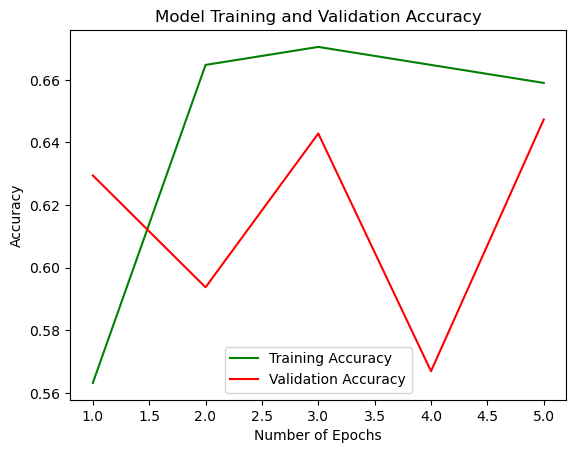

In [407]:
# Extracting accuracy values for the optimized model
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Creating epochs range for x-axis
epochs = range(1, len(train_accuracy) + 1)

# Plotting accuracy results
plt.plot(epochs, train_accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Model Training and Validation Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plot
plt.show()

## FURTHER TESTS, EVALUATION METRICS, AND RESULTS

Based on the evaluation metrics, model optimizations led to a better performance for the model. In addition to the increased test accuracy, I also plotted the MSE (mean-squared error) metrics for each epoch from the training process. The plot reveals fluctations in the validation MSE metrics, indicating that the model is initially struggling with learning the data. However, based on the readouts from the training process, the validation does appear to have an overall increase in accuracy. Increasing the dropout rate, decreasing the learning rate, and including additional dropout layers seems to improve the overall model, and these would be hyperparameters worth exploring further for optimization purposes. For further tests, I would also increase the number of epochs and change the batch size to see how the model behavior changes for higher epochs and other parameter conditions.

In [411]:
# Evaluating the model on the separate test set
test_accuracy = optimized_model.evaluate(test_data, test_labels)
print("Test Accuracy:", test_accuracy)

10/10 [==============================] - 17s 2s/step - loss: 0.3616 - accuracy: 0.5969 - mse: 0.3616
Test Accuracy: [0.36164557933807373, 0.596875011920929, 0.36164557933807373]


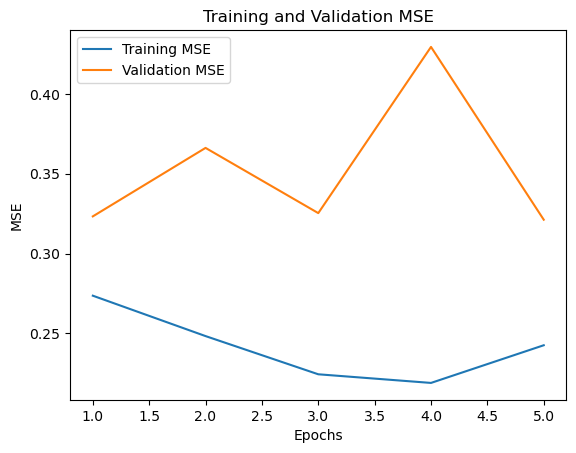

In [409]:
# Extracting the MSE values from the optimized model
mse = history.history['mse']
val_mse = history.history['val_mse']

# Plotting the MSE values against the number of epochs
epochs = np.arange(1, len(mse) + 1)

plt.plot(epochs, mse, label='Training MSE')
plt.plot(epochs, val_mse, label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

## DISCUSSION, LESSONS LEARNED, AND CONCLUSION

Overall, I was able to achieve success in my project objectives: (1) succeed in having the transformer model learn from the data and (2) identify adjustable hyperparameters in improving the model performance. I identified the following hyperparameters so far that impact the model: dropout rate, number of dropout and batch normalization layers, learning rate, number of encoding layers, and number of transformer blocks.  For further experimentation, I would also increase the number of epochs and modify the batch size. <br>

One of the most critical lessons taken from this project (which also addresses one of the more challenging aspects of the project) was properly defining a model architecture that is applicable to the given use case. I had to make many modifications to have the transformer model work, which included removing core components (such as positional encoding). Nevertheless, I managed to establish a working architecture and obtain certain success from the training and testing processes. <br>

The project shows that it is possible to implement a transformer model approach for cataract image classification. More experimentation is needed in order to achieve higher accuracies with the transformer model (as well as with other different types of transformer models).